# Saving kinematics and neural data segments

In [1]:
import aopy
from aopy.data import db
import seaborn as sns
import pickle

/home/aolab/miniconda3/envs/leo-analysis/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Version of aopy used: 
!pip freeze | grep aopy

-e git+https://github.com/aolabNeuro/analyze.git@7e7db7fccb1639273553b9eb907cac36eff6a466#egg=aolab_aopy
aopy==0.6.0


## Define what to save

In [8]:
def save_kinematics_and_lfp(preproc_dir, subject, date_range):
    entries = db.lookup_mc_sessions(subject=subject, date=date_range)
    subjects, ids, dates = db.list_entry_details(entries)
    df = aopy.data.tabulate_behavior_data_center_out(preproc_dir, subjects, ids, dates)
    
    # Choose just the trials with completed reach segments
    df_subset = df[df['reach_completed']].reset_index()
    
    # Get the reach segments kinematics
    kin_segments = aopy.data.bmi3d.tabulate_kinematic_data(
        preproc_dir, df_subset['subject'], df_subset['te_id'], df_subset['date'], 
        df_subset['go_cue_time'], df_subset['reach_end_time'], datatype='cursor'
    )
    
    target_idx = df_subset['target_idx'].to_numpy()
    aopy.visualization.color_trajectories(kin_segments, target_idx, sns.color_palette(n_colors=9))
    
    # Choose some data around go cue
    lfp_segments, samplerate = aopy.data.tabulate_ts_segments(
        preproc_dir, df_subset['subject'], df_subset['te_id'], df_subset['date'], 
        df_subset['go_cue_time'], df_subset['reach_end_time'], datatype='lfp'
    )
    
    _, acq_ch, _ = aopy.data.load_chmap()
    
    # Save as pickle file for each subject:
    # kin_segments - list of (nt, 2) x, y cursor positions
    # lfp_segments - list of (nt, 240) ecog data from 240 array over motor cortex
    # samplerate - sampling rate of both data
    filename = f'{subject}_{date_range[0]}_{date_range[1]}_kinematics_and_lfp.pkl'
    write_dir = './'
    data_dict = {
        'kin_segments': kin_segments, 
        'lfp_segments': [seg[:,acq_ch-1] for seg in lfp_segments], 
        'samplerate': samplerate
    }
    aopy.data.pkl_write(filename, data_dict, write_dir)

In [9]:
# 'beignet': ex_date_list = [(2022,6,28)]
preproc_dir = '/data/preprocessed'
subject = 'beignet'
date_range = ('2022-06-28', '2022-06-29')


## Save data

  0%|          | 0/1 [00:00<?, ?it/s]

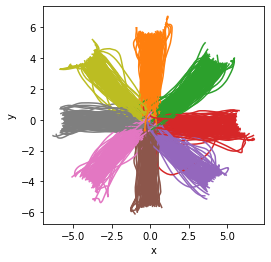

In [10]:
save_kinematics_and_lfp(preproc_dir, subject, date_range)

  0%|          | 0/17 [00:00<?, ?it/s]

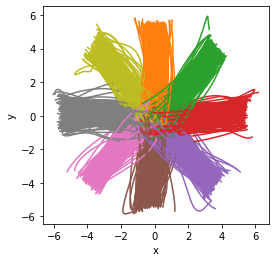

In [48]:
# For Affi: ex_date_list = [(2024,1,2),(2024,1,3)]
subject = 'affi'
date_range = ('2024-01-02', '2024-01-04')

save_kinematics_and_lfp(preproc_dir, subject, date_range)

## Load data

In [ ]:
# Saved as pickle file for each subject:
# kin_segments - list of (nt, 2) x, y cursor positions
# lfp_segments - list of (nt, 240) ecog data from 240 array over motor cortex
# samplerate - sampling rate of both data

In [54]:
# How to load data:
file = './beignet_2022-06-28_2022-06-29_kinematics_and_lfp.pkl'
with open(file, "rb") as f:
    data_dict = pickle.load(f)

In [55]:
print(len(data_dict['kin_segments']))

823


In [56]:
file = './affi_2024-01-02_2024-01-04_kinematics_and_lfp.pkl'
with open(file, "rb") as f:
    data_dict = pickle.load(f)

In [57]:
print(len(data_dict['kin_segments']))

1739
